# Evaluate success of events - bottom plot needs footfall_spatial env

In [31]:
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
import joblib
import os
import io
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx

from Functions import *

In [32]:
api = "6c2695a3-768a-4885-a408-5770a99f5269"

### Load fitted model

In [33]:
buffer_size_m = 400
rf_model_pipeline1 = joblib.load(f'Results/FinalModels/rf_model_pipeline1_{buffer_size_m}.pkl')

### Read in Melbourne sensor location data

In [34]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

### Get data to make prediction on 

In [35]:
input_csv="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)
sensor_ids = pd.read_csv(input_csv)['sensor_id']

### Get data for just one day 

In [36]:
Xfull_with_dates = Xfull.copy()
Xfull['datetime'] = data_time_columns['datetime']
Xfull['datetime'] = pd.to_datetime(Xfull['datetime'], errors='coerce')

# Date of interest
special_date =  '2015-04-25' # '2015-04-25' # 2019-01-01 #2020-03-20

# Get data just from this date
special_date_data = Xfull[Xfull['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

# Get real vals from just this date
special_date_real_vals = pd.DataFrame({'Real_vals':Yfull, 'Hour': data_time_columns['time'],'datetime':data_time_columns['datetime']})
special_date_real_vals['datetime'] = pd.to_datetime(special_date_real_vals['datetime'], errors='coerce')
special_date_real_vals = special_date_real_vals[special_date_real_vals['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

In [37]:
special_date_real_vals = pd.DataFrame({'Real_vals':Yfull, 'Hour': data_time_columns['time'],'datetime':data_time_columns['datetime'],
                                      'sensor_id': sensor_ids})
special_date_real_vals['datetime'] = pd.to_datetime(special_date_real_vals['datetime'], errors='coerce')
special_date_real_vals = special_date_real_vals[special_date_real_vals['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

### Prepare it for using the model to make predictions

In [38]:
# If using the cyclical variables
special_date_data.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year', 'datetime'], axis=1, inplace = True)

### Use the model to make predictions

In [39]:
preds = rf_model_pipeline1.predict(special_date_data)

### Make a dataframe containing the model's predictions and the real values

In [40]:
df_preds_real_vals = pd.DataFrame({'Preds':preds,'RealVals':special_date_real_vals['Real_vals'], 
                                   'Hour': special_date_real_vals['Hour'],
                                  'sensor_id': special_date_real_vals['sensor_id']})

### Find the sum of the values across all sensors for each hour

In [41]:
df_preds_real_vals_hourly =df_preds_real_vals.groupby(['Hour']).sum()

### Add percentage increase

In [42]:
df_preds_real_vals_hourly['Percentage_Increase'] = ((df_preds_real_vals_hourly['RealVals'] - df_preds_real_vals_hourly['Preds']) / abs(df_preds_real_vals_hourly['Preds'])) * 100

## Make line plot

In [43]:
include_percent_increase = True

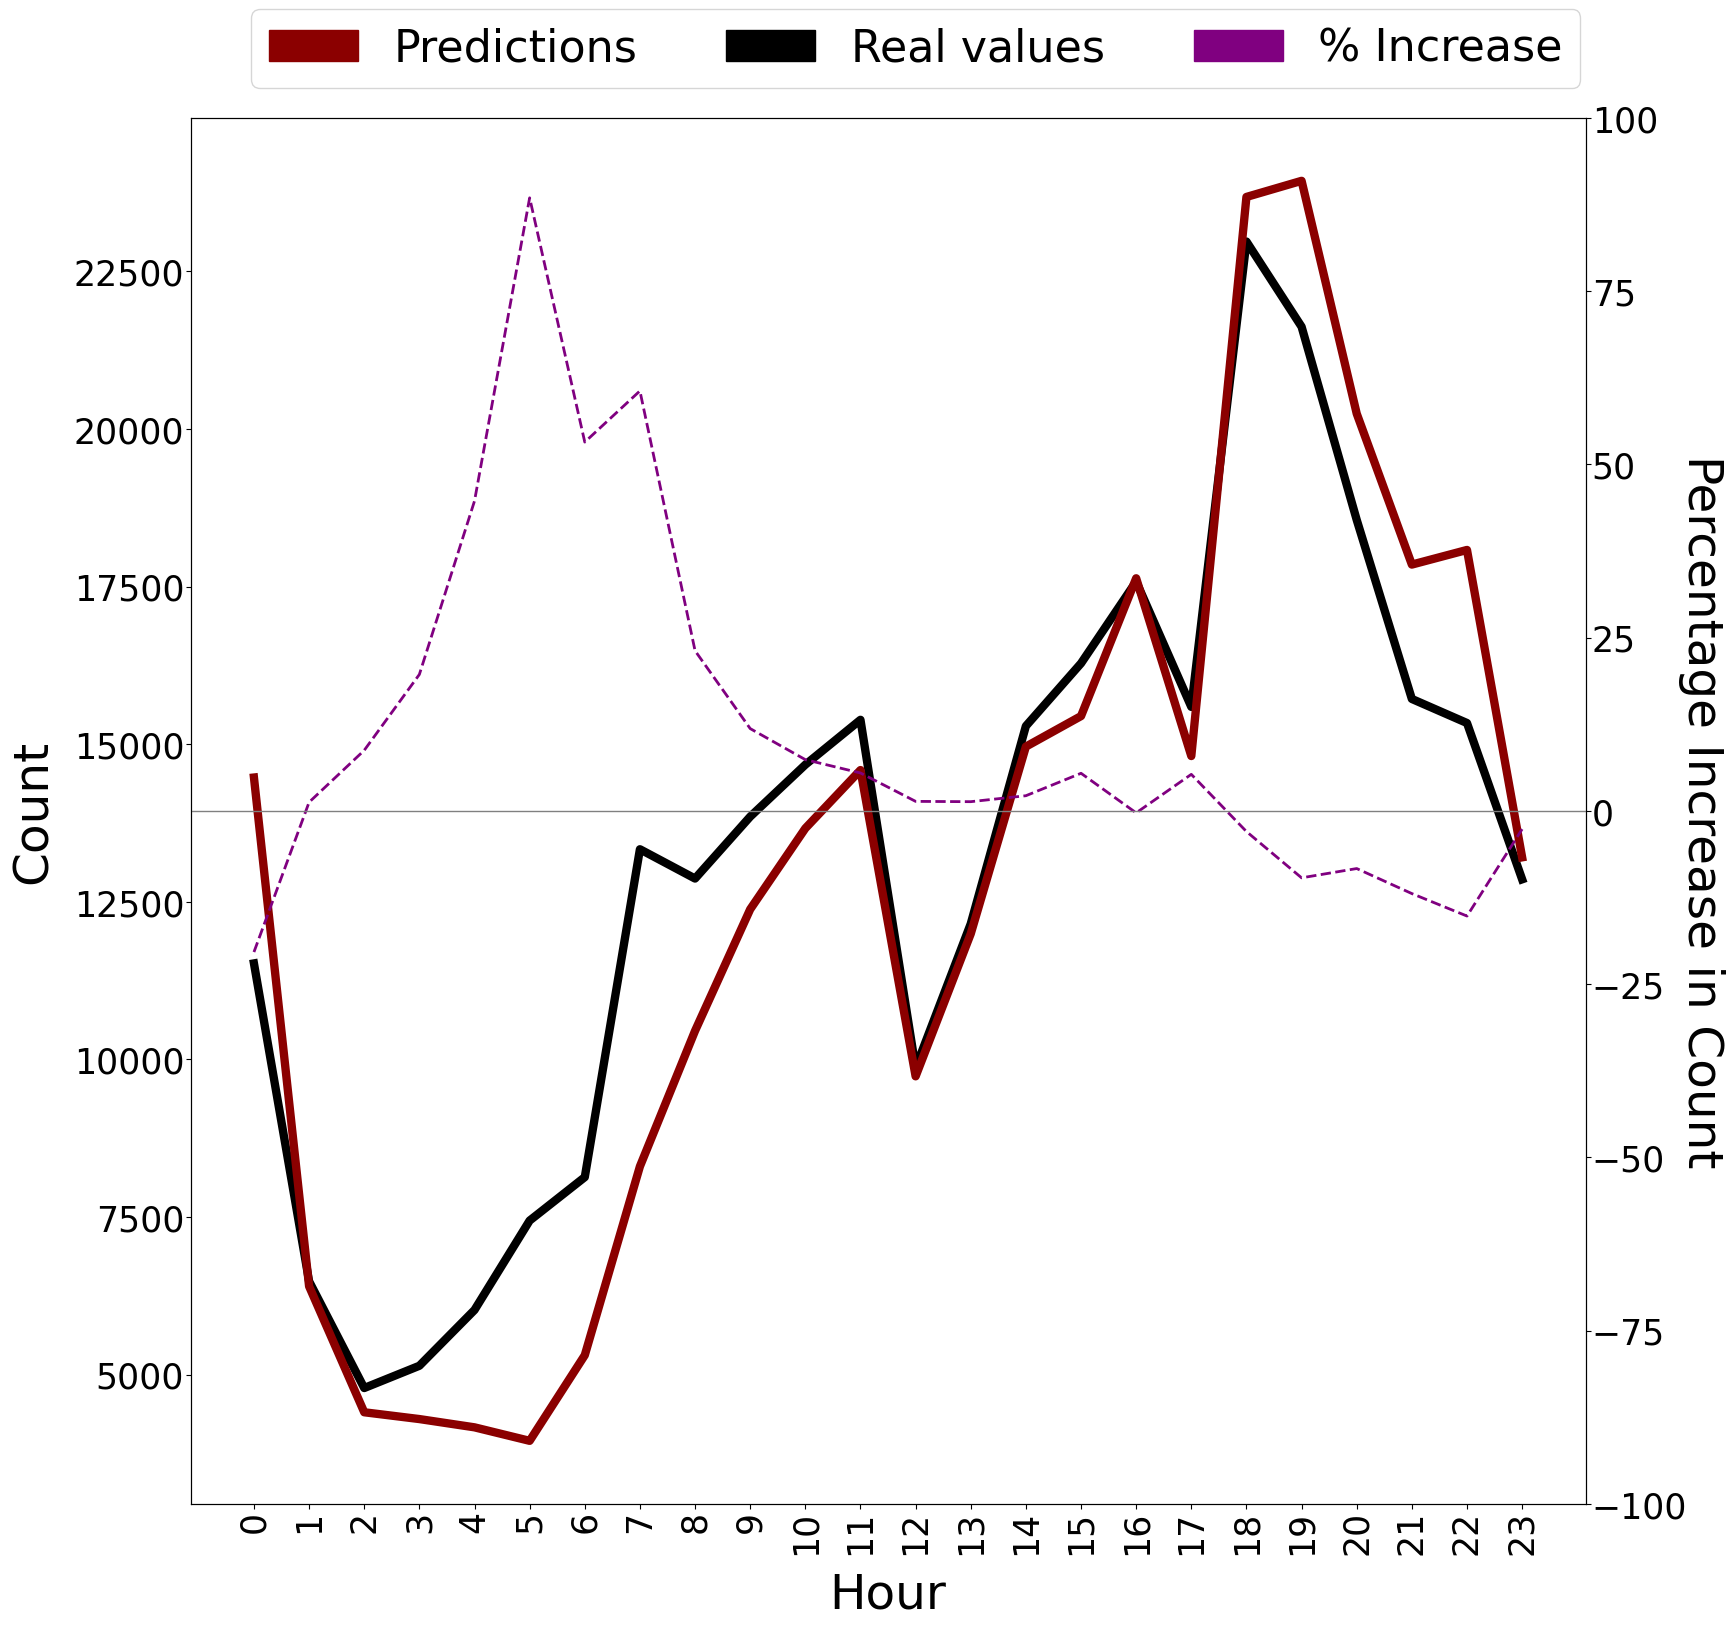

In [44]:
fig, ax = plt.subplots(figsize = (18,18), sharex = True)

fig = df_preds_real_vals_hourly['RealVals'].plot(ax=ax, color='black', linewidth=6, legend =False)
fig = df_preds_real_vals_hourly['Preds'].plot(ax=ax, color='darkred', linewidth=6, legend =False)

colors_leg = ['darkred', 'black', 'purple']
texts = ['Predictions', 'Real values','% Increase'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]    

ax.set_xticks(range(0,len(df_preds_real_vals_hourly.index)))
ax.set_xticklabels(df_preds_real_vals_hourly.index, size=15)
ax.tick_params(axis='both', which='major', labelsize=25, pad=1)

ax.set_xlabel('Hour', fontsize = 35, labelpad=12)
ax.set_ylabel ('Count',fontsize=35, labelpad=12)

if include_percent_increase==True:
    ax2 = ax.twinx()
    fig = df_preds_real_vals_hourly['Percentage_Increase'].plot(ax=ax2, color='purple', linewidth=2, legend =False,
                                                               linestyle = 'dashed')
    ax2.set_ylabel('Percentage Increase in Count', fontsize=35, rotation=270, labelpad=27)
    ax2.tick_params(axis='both', which='major', labelsize=25, pad=1)
    ax2.set_ylim(-100,100)

plt.axhline(y = 0, color = 'grey', linestyle = '-', linewidth=1)     
    
# ax.set_title(special_date)
ax.tick_params(axis='x', rotation=90)
plt.legend(handles=patches, bbox_to_anchor=(0.52, 1.05), loc='center', ncol=3, prop={'size': 32});
plt.savefig("Results/ModelEvaluation/Events/{}_lines.png".format(special_date), bbox_inches="tight" )
# plt.close() 

## Find errors by sensors

In [45]:
df_preds_real_vals_sensorly =df_preds_real_vals.groupby(['sensor_id']).sum()
df_preds_real_vals_sensorly.drop(['Hour'], axis=1, inplace=True)

### Add error metrics
df_preds_real_vals_sensorly['AbsolouteError'] = abs(df_preds_real_vals_sensorly['RealVals']-df_preds_real_vals_sensorly['Preds'])
df_preds_real_vals_sensorly['Error'] = df_preds_real_vals_sensorly['RealVals']-df_preds_real_vals_sensorly['Preds']
df_preds_real_vals_sensorly['Percentage_Increase'] = ((df_preds_real_vals_sensorly['RealVals'] - df_preds_real_vals_sensorly['Preds']) / abs(df_preds_real_vals_sensorly['Preds'])) * 100

# ### Join back with sensor geographic data
df_preds_real_vals_sensorly = pd.merge(df_preds_real_vals_sensorly, melbourne_sensors[['Latitude', 'Longitude', 'sensor_id']], on='sensor_id', how='left')
df_preds_real_vals_sensorly.head()

,sensor_id,Preds,RealVals,AbsolouteError,Error,Percentage_Increase,Latitude,Longitude
0,1,9965.14,9168,797.14,-797.14,-7.999286,-37.813494,144.965153
1,2,9138.01,9655,516.99,516.99,5.657578,-37.813807,144.965167
2,3,16722.10,17873,1150.90,1150.90,6.882509,-37.811015,144.964295
3,4,14751.52,15170,418.48,418.48,2.836860,-37.814880,144.966088
4,5,14015.04,14518,502.96,502.96,3.588716,-37.818742,144.967877


## Make spatial plot

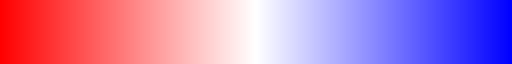

In [46]:
norm=plt.Normalize(-2,2)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
cmap

In [47]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-69.19517910546156, vcenter=0., vmax=40)

In [48]:
# geometry = [Point(xy) for xy in zip(df_preds_real_vals_sensorly.Longitude, df_preds_real_vals_sensorly.Latitude)]
# gdf = gpd.GeoDataFrame(df_preds_real_vals_sensorly, geometry=geometry)
# gdf = gdf.set_crs(epsg=4326)
# gdf = gdf.to_crs('epsg:3857')

# fig, ax = plt.subplots(figsize=(15,15))
# gdf.plot(column=gdf.Percentage_Increase, ax = ax, markersize = 900,edgecolor = 'black', cmap="RdBu", norm=divnorm,
#          marker='h', legend = True, 
#          legend_kwds={'shrink': 0.9, 'pad':0.01, 'label':'Percentage Increase', 
#                       "orientation": "horizontal"})

# # Change font size on legend
# cb_ax = fig.axes[1]
# cb_ax.tick_params(labelsize=20)
# plt.rcParams.update({'font.size': 35}) # legend title size

# cx.add_basemap(ax, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.png?api_key='+api)
# ax.axis('off')
# ax.set_axis_off()

# fig.savefig("Results/ModelEvaluation/Events/{}_spatial.png".format(special_date), bbox_inches="tight" )

## Make two plots together

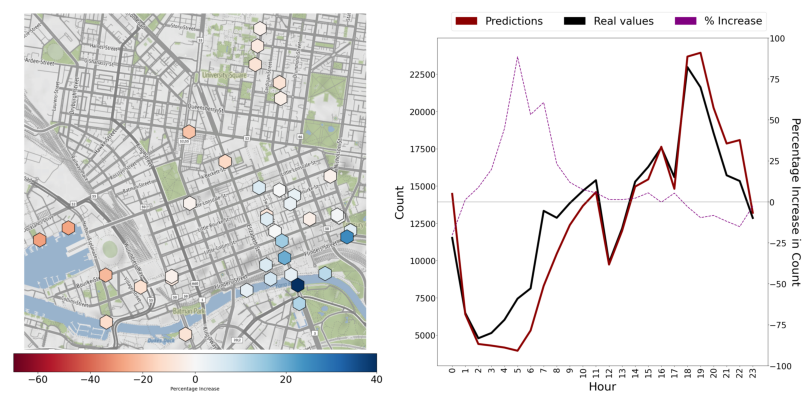

In [49]:
img1 = mpimg.imread('Results/ModelEvaluation/Events/{}_spatial.png'.format(special_date))
img2 = mpimg.imread('Results/ModelEvaluation/Events/{}_lines.png'.format(special_date))

fig, axs = plt.subplots(ncols= 2, nrows=1,figsize = (11,5), gridspec_kw={'wspace': -0.12})
axs[0].imshow(img1)
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].axis('off');
plt.savefig('Results/ModelEvaluation/Events/{}_lines_spatial.png'.format(special_date), bbox_inches='tight')

### More assessment of changes

In [53]:
df_preds_real_vals_hourly.reset_index(inplace=True)

In [50]:
current = df_preds_real_vals_hourly['RealVals'].sum()
previous = df_preds_real_vals_hourly['Preds'].sum()

change_percent = ((float(current)-previous)/previous)*100
change_percent

3.1293275300083363

In [54]:
hours = [3,4,5,6,7,8,9,10]
# hours = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

current = df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin(hours)]['RealVals'].sum()
previous = df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin(hours)]['Preds'].sum()

change_percent = ((float(current)-previous)/previous)*100
change_percent

30.31051540996026

In [55]:
# # Overall change
# df_preds_real_vals_hourly['RealVals'].sum()/df_preds_real_vals_hourly['Preds'].sum() * 100
# # Change between these hours
# df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin([3,4,5,6,7,8,9])]['RealVals'].sum()/df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin([3,4,5,6,7,8,9])]['Preds'].sum() * 100

In [57]:
# df_preds_real_vals_sensorly.sort_values(by='Percentage_Increase', ascending = False)
# df_preds_real_vals_sensorly[df_preds_real_vals_sensorly['sensor_id'] ==29]

In [58]:
# Change for one sensor
sensor_29 = df_preds_real_vals[df_preds_real_vals['sensor_id']==29]
sensor_29['Percentage_Increase'] = ((sensor_29['RealVals'] - sensor_29['Preds']) / abs(sensor_29['Preds'])) * 100
sensor_29

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Preds,RealVals,Hour,sensor_id,Percentage_Increase
813635,169.71,118,0,29,-30.469625
813661,80.67,90,1,29,11.565638
813701,61.14,73,2,29,19.398103
813726,92.69,303,3,29,226.896105
813860,997.85,1548,6,29,55.133537
813901,1004.20,2182,7,29,117.287393
814113,1117.29,1637,14,29,46.515229
814130,444.15,1379,15,29,210.480693
814162,765.20,959,16,29,25.326712
814189,683.88,934,17,29,36.573668
